<h1 align="center">Task 3E: Symmetry project for End-to-End Particle Reconstruction</h1>

---

● __Dataset Preparation__: Use the vanilla _MNIST_ dataset for this purpose. Rotate every sample in steps of 30 degrees and store them in a data format of your choice. Only use the digits 1 and 2 from the dataset if the computational budget is limited.

● __Latent Space Creation__: Build an Auto-Encoder of your choice and train it using the dataset prepared in the previous step.

● __Dataset Distillation__: Devise a strategy to remove the samples that the AE poorly reconstructs to remove outliers.

● __Lie Group Generation__: Using the latent vectors from the AE construct an Infinitesimal operator that represents the rotation group but in the latent space. Refer to the <a href="https://arxiv.org/abs/2302.00236">paper</a> for more information on the training scheme.

● __Lie Group Action__: Demonstrate the rotation action of the operator by applying it to
an arbitrary latent vector from the dataset and decoding it using the decoder of the
AE.

---

In [1]:
import os
import gc
from random import shuffle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn, optim

from torch.nn import functional as F

from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from torchvision.datasets import MNIST
from torchvision import transforms as T
from torchvision import models

---

<h2 align="center">Phase I: Data Preparation</h2>

__Aim__: Use the vanilla MNIST dataset for this purpose. Rotate every 
sample in steps of 30 degrees and store them in a data format of your choice. Onl 
use the digits 1 and 2 from the dataset if the computational budget is limited.

---

First, I load the _MNIST_ dataset.

In [3]:
# Load data files
train_dataset = MNIST(root = ".", download = True, train = True)
test_dataset = MNIST(root = ".", download = True, train = False)

100%|██████████| 9912422/9912422 [00:00<00:00, 92600776.08it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37433774.36it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23056429.79it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6983331.66it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
# Get image-label pair at index 0
index = 0
train_dataset.__getitem__(index)

(<PIL.Image.Image image mode=L size=28x28>, 5)

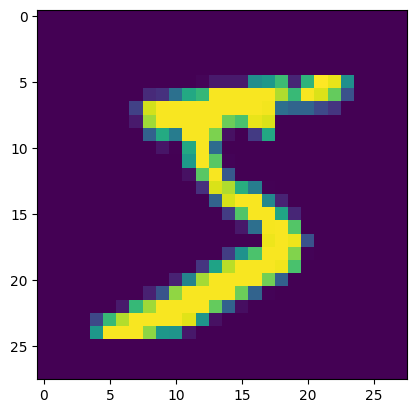

In [5]:
plt.imshow(train_dataset[0][0])

---

The images in the dataset need to be rotated incrementally by 30 degrees. This will effectively increase the size of the dataset by a factor of 12.

In [6]:
360/30

12.0

In [7]:
[30 * n for n in range(1, 12)]

[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]

---

It is stated in the document that the rotated images should be stored in a format of choice. I however ellect to go against this specific instruction for the following reasons:

1. __I/O-bound Operations__: Persisting 720,000 images might lead to issues with IO.

In [8]:
class MNISTDataset(Dataset):
    def __init__(self, dataset, return_tensor = False):
        super().__init__()

        self.return_tensor = return_tensor

        self.base_rotator = T.Compose(
            [
                T.ToTensor(),
                T.Normalize([0.5,], [0.5,])
            ]
        )

        self.rotators = [
            T.Compose(
                [
                    T.ToTensor(),
                    T.Normalize([0.5,], [0.5,]),
                    T.RandomRotation((30 * factor, 30 * factor)),
                ]
            )

            for factor in range(1, 12)
        ]

        self.dataset = dataset
        
    def __getitem__(self, index):
        mapped_index = int(index / 12) # Index to base image to be rotated
        rotation_index = index % 12    # Index for angular rotation to be applied
        
        image, label = self.dataset.__getitem__(mapped_index)
        image = self.rotators[rotation_index - 1](image) if rotation_index > 0 else self.base_rotator(image)
        
        return (image, label) if self.return_tensor else (T.ToPILImage()(image), label)
        

    def __len__(self):
        return self.dataset.__len__() * 12

In [9]:
train_dataset = MNISTDataset(dataset = train_dataset)
test_dataset = MNISTDataset(dataset = test_dataset)

In [10]:
train_dataset[11]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [11]:
test_dataset[11]

(<PIL.Image.Image image mode=L size=28x28>, 7)

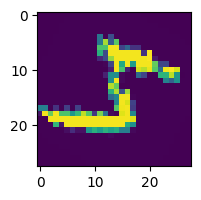

In [12]:
plt.figure(figsize = (2, 2))
plt.imshow(train_dataset[11][0])
plt.show(); plt.close("all")

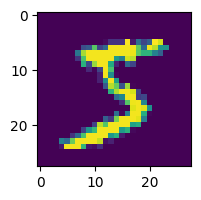

In [13]:
plt.figure(figsize = (2, 2))
plt.imshow(train_dataset[0][0])
plt.show(); plt.close("all")

In [14]:
train_dataset.dataset[1]

(<PIL.Image.Image image mode=L size=28x28>, 0)

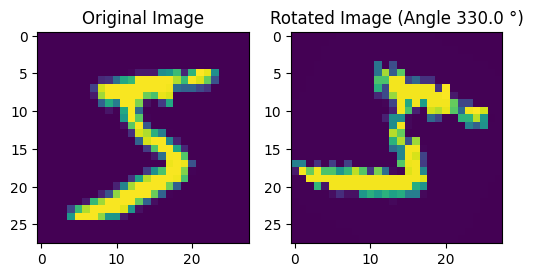

In [15]:
index = 11
rotation_index = index % 12
real_index = int(index / 12)

angle = 0 if rotation_index == 0 else train_dataset.rotators[rotation_index - 1].transforms[-1].degrees[0]

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 3))

axes[0].imshow(train_dataset.dataset[real_index][0])
# axes[1].imshow(train_dataset[12][0])
axes[1].imshow(train_dataset[index][0])

axes[0].set_title("Original Image")
axes[1].set_title(f"Rotated Image (Angle {angle} °)")

plt.show(); plt.close("all")

---

Next, I define dataloaders from the datasets.

In [16]:
# Ensure datasets return tensors
train_dataset.return_tensor = True
test_dataset.return_tensor = True

In [17]:
BATCH_SIZE = 128

train_dl = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, pin_memory = True)

In [18]:
s = next(iter(train_dl))

In [19]:
s[0].shape

torch.Size([128, 1, 28, 28])

In [20]:
s[0].max()

tensor(1.)

In [21]:
s[0].min()

tensor(-1.)

In [22]:
gc.collect()

2789

---

<h2 align="center">Phase II: Latent Space Creation</h2>

__Aim__: Build an Auto-Encoder of your choice and train it using the 
dataset prepared in the previous step.

---

In [23]:
class ParticleEncoder(nn.Module):
    def __init__(self, latent_dim, p = .4):
        super(ParticleEncoder, self).__init__()
        
        self.latent_dim = latent_dim
        self.p = p
        
        self.l1 = nn.Conv2d(in_channels = 1, out_channels = 8, stride = 1, padding = 1, kernel_size = 3)
        self.b1 = nn.BatchNorm2d(8)
        self.d1 = nn.Dropout(self.p)
        
        self.l2 = nn.Conv2d(in_channels = 8, out_channels = 16, stride = 1, padding = 1, kernel_size = 3)
        self.b2 = nn.BatchNorm2d(16)
        self.d2 = nn.Dropout(self.p)
        
        self.l3 = nn.Conv2d(in_channels = 16, out_channels = 32, stride = 3, padding = 1, kernel_size = 3)
        self.b3 = nn.BatchNorm2d(32)
        self.d3 = nn.Dropout(self.p)
        
        self.l4 = nn.Conv2d(in_channels = 32, out_channels = 64, stride = 2, padding = 1, kernel_size = 2)
        self.b4 = nn.BatchNorm2d(64)
        
        self.linear = nn.Linear(64*6*6, self.latent_dim)
        
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        y = self.d1(F.relu(self.b1(self.l1(x))))
        y = self.d2(F.relu(self.b2(self.l2(y))))
        y = self.d3(F.relu(self.b3(self.l3(y))))
        
        y = F.relu(self.b4(self.l4(y)))
        
        y = self.flatten(y)
        y = self.linear(y)
        
        return y

In [24]:
class ParticleDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(ParticleDecoder, self).__init__()
        
        self.latent_dim = latent_dim

        self.linear = nn.Linear(self.latent_dim, 64*6*6)
        
        self.l1 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1, stride = 3)
        self.b1 = nn.BatchNorm2d(32)
        
        self.l2 = nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 2, padding = 2, stride = 2)
        self.b2 = nn.BatchNorm2d(16)
        
        self.l3 = nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 2, padding = 2, stride = 2)
        self.b3 = nn.BatchNorm2d(8)
        
        self.l4 = nn.Conv2d(in_channels = 8, out_channels = 1, kernel_size = 2, padding = 2, stride = 2)
        
    def forward(self, x):
        x = F.relu(self.linear(x))
        y = F.relu(self.b1(self.l1(x.view(-1, 64, 6, 6))))
        y = F.relu(self.b2(self.l2(y)))
        y = F.relu(self.b3(self.l3(y)))
        
        y = torch.tanh(self.l4(y).view(-1, 1, 28, 28))
        
        return y
        

In [25]:
class ParticleAutoEncoder(nn.Module):
    def __init__(self, in_dim = 128, out_dim = 128, encoder = None, decoder = None):
        super(ParticleAutoEncoder, self).__init__()

        self.in_dim, self.out_dim = in_dim, out_dim
        
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x_encoded = self.encoder(x)
        return self.decoder(x_encoded)

    @torch.no_grad()
    def generate_images(self, x_, code_type = 'code'):
        self.eval()
        if code_type == 'code':
            img = self.decoder(x_)
        elif code_type == 'image':
            img = self(x_)
        else:
            raise Exception('Provide a random code [-1, 1] or an image [-1, 1, 28, 28].')
        
        return img

    @torch.no_grad()
    def generate_code(self, image):
        self.eval()
        code = self.encoder(image)
        return code

In [26]:
def initialize_weights(model):
    for (name, weights) in filter(lambda x: x[1].requires_grad, model.named_parameters()):
        if name.split(".")[1] not in ["fc", "conv1"]:
            continue
        try:
            nn.init.kaiming_normal_(weights)
        except:
            nn.init.normal_(weights, 0., 0.05)
    
    return model

def get_l2_loss(model):
    return sum([x ** 2 for x in model.parameters()])

In [27]:
def weight_initializer(model):
    for layer in model.children():
        if 'Conv' in str(type(layer)):
            nn.init.normal_(layer.weight, 0, 0.5)
        elif 'Linear' in str(type(layer)):
            nn.init.xavier_normal_(layer.weight, 1.0)
    
    return model

In [28]:
latent_dim = 32

In [29]:
encoder = ParticleEncoder(latent_dim = latent_dim)
decoder = ParticleDecoder(latent_dim = latent_dim)

In [30]:
model = ParticleAutoEncoder(encoder = encoder.apply(weight_initializer), decoder = decoder.apply(weight_initializer))

In [31]:
model

ParticleAutoEncoder(
  (encoder): ParticleEncoder(
    (l1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d1): Dropout(p=0.4, inplace=False)
    (l2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d2): Dropout(p=0.4, inplace=False)
    (l3): Conv2d(16, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (b3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d3): Dropout(p=0.4, inplace=False)
    (l4): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (b4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear): Linear(in_features=2304, out_features=32, bias=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): ParticleDecoder(
    (linear): Linear

In [32]:
sample_input = torch.randn(8, 1, 28, 28)

In [33]:
out = model(s[0])

In [34]:
out.shape

torch.Size([128, 1, 28, 28])

In [35]:
for name, p in model.named_parameters():
    print(name)

encoder.l1.weight
encoder.l1.bias
encoder.b1.weight
encoder.b1.bias
encoder.l2.weight
encoder.l2.bias
encoder.b2.weight
encoder.b2.bias
encoder.l3.weight
encoder.l3.bias
encoder.b3.weight
encoder.b3.bias
encoder.l4.weight
encoder.l4.bias
encoder.b4.weight
encoder.b4.bias
encoder.linear.weight
encoder.linear.bias
decoder.linear.weight
decoder.linear.bias
decoder.l1.weight
decoder.l1.bias
decoder.b1.weight
decoder.b1.bias
decoder.l2.weight
decoder.l2.bias
decoder.b2.weight
decoder.b2.bias
decoder.l3.weight
decoder.l3.bias
decoder.b3.weight
decoder.b3.bias
decoder.l4.weight
decoder.l4.bias


---

Now, I define a function to initialize model weights.

---

In [36]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
DEVICE

device(type='cuda')

In [38]:
model = model.to(DEVICE)

# model = initialize_weights(model)

In [39]:
EPOCHS = 20
l2_lambda = 1e-5

criterion = nn.MSELoss().to(DEVICE)

# Optimizer hyperparameters
LR = 1e-2
FACTOR = 10
AMSGRAD = False
BETAS = (.9, .999)

optimizer = optim.AdamW([{'params': encoder.parameters()}, {'params': decoder.parameters()}],
                        lr = .001, weight_decay = 1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 2, min_lr = 0.0001)

In this notebook, the pretrained weights will be finetuned. This is in contrast to the previous one, where the weights were kept frozen. Also, the learing rate is increased from 1e-4 to 1e-3.

In [40]:
opt = optim.AdamW(
    params = [
        {
            "params" : model.encoder.parameters(),
            "lr": LR
        },
        {
            "params" : model.decoder.parameters(),
            "lr": LR
        }
    ],
    lr=LR/FACTOR,
    amsgrad = AMSGRAD,
    betas = BETAS,
    weight_decay = l2_lambda
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience = 2, min_lr = 1e-4)

In [41]:
def get_l2_loss(model):
    l2_loss = torch.tensor(0.).cuda()
    l2_loss += sum(map(lambda x: x.data.pow(2).sum(), filter(lambda x: x.requires_grad, model.parameters())))
    return l2_loss

In [42]:
from sklearn.metrics import accuracy_score

In [43]:
### Code mean (determined via pretraining)
MEAN = .02
STD = .233

In [44]:
def training_loop(epochs, model, optimizer):
    TRAIN_LOSSES, TEST_LOSSES = [], []

    for epoch in range(1, epochs + 1):
        train_losses, test_losses = [], []

        model.train() # Set up training mode

        for batch in iter(train_dl):
            # X, y = collate_function(batch)
            X, y = batch
            X, y = X.to(DEVICE), y.view(-1).to(DEVICE)

            optimizer.zero_grad()

            y_pred = model(X)
            
            # Uncomment the line below if the criterion is nn.NLLLoss()
            # y_pred = torch.log_softmax(y_pred, dim = -1)

            # Compare actual targets and predicted targets to get the loss
            train_loss = criterion(y_pred, X) #+ (l2_lambda * get_l2_loss(model))
            # Backpropagate the loss
            train_loss.backward()
            
            optimizer.step()

            train_losses.append(train_loss.detach().item())

        scheduler.step(train_loss)
        
        with torch.no_grad(): # Turn off computational graph
            model.eval() # Set model to evaluation mode
            for batch in iter(test_dl):
                # X_, y_ = collate_function(batch)
                X_, y_ = batch
                X_, y_ = X_.to(DEVICE), y_.view(-1).to(DEVICE)
    
                y_pred_ = model(X_)
                
                # Uncomment the line below if the criterion is nn.NLLLoss()
                # y_pred_ = torch.log_softmax(y_pred_, dim = -1)
    
                # Compare actual targets and predicted targets to get the loss
                test_loss = criterion(y_pred_, X_) #+ (l2_lambda * get_l2_loss(model))
                test_losses.append(test_loss.item())


        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_test_loss = sum(test_losses) / len(test_losses)

        print(
            f"Epoch: {epoch} | Train MSE loss: {avg_train_loss: .3f} | Test MSE loss: {avg_test_loss: .3f} |"
        )

        TRAIN_LOSSES.append(avg_train_loss)
        TEST_LOSSES.append(avg_test_loss)

        img = model.generate_images(
            x_ = torch.distributions.Normal(loc = MEAN, scale = STD).sample((32, latent_dim)).clip(0, 1).to(DEVICE),
            code_type = 'code'
        )
        
        fig, ax = plt.subplots(nrows = 4, ncols = 8, figsize = (10, 5))

        ix = 0
        for i in range(4):
            for j in range(8):
                ax[i, j].imshow(img[ix].cpu().squeeze(), 'gray')
                ix += 1
        
        plt.tight_layout(h_pad = 0.01)
        plt.show(); plt.close('all')

        print("\n\n\n" + "="*145)


    # Clear CUDA cache
    torch.cuda.empty_cache()
    torch.clear_autocast_cache()

    return {
        "loss": [TRAIN_LOSSES, TEST_LOSSES],
        "model": model
    }

Epoch: 1 | Train MSE loss:  0.104 | Test MSE loss:  0.074 |


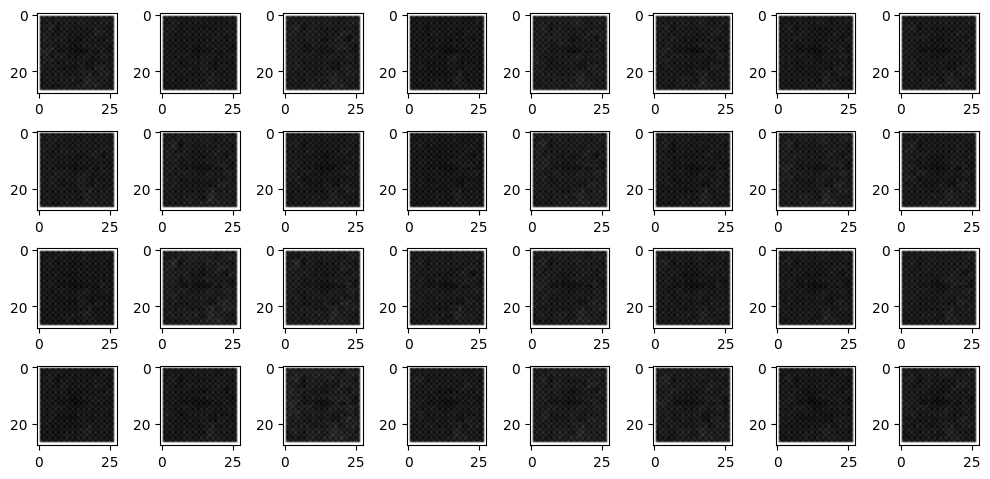




Epoch: 2 | Train MSE loss:  0.077 | Test MSE loss:  0.071 |


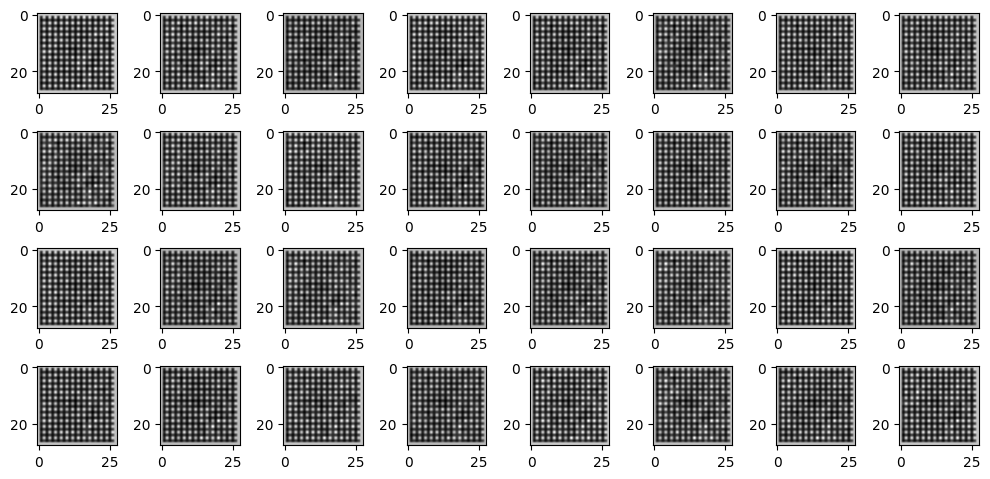




Epoch: 3 | Train MSE loss:  0.074 | Test MSE loss:  0.074 |


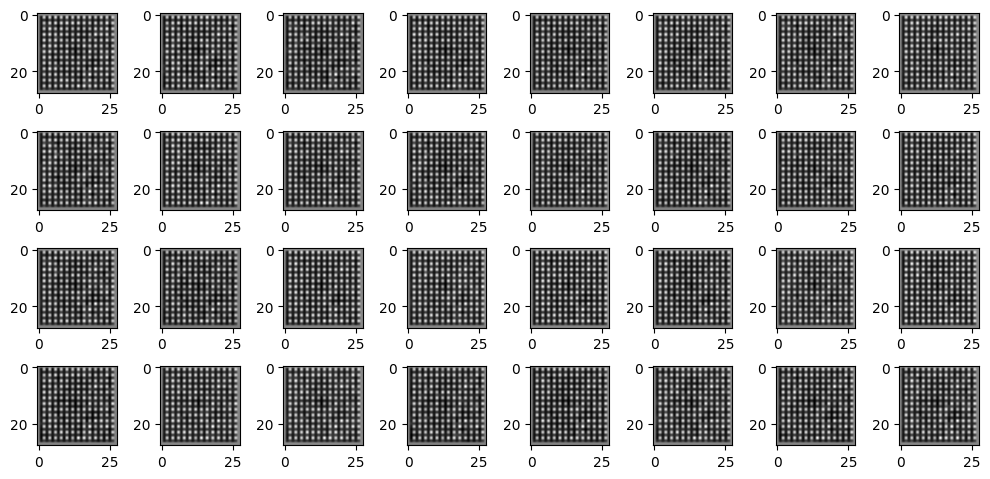




Epoch: 4 | Train MSE loss:  0.073 | Test MSE loss:  0.070 |


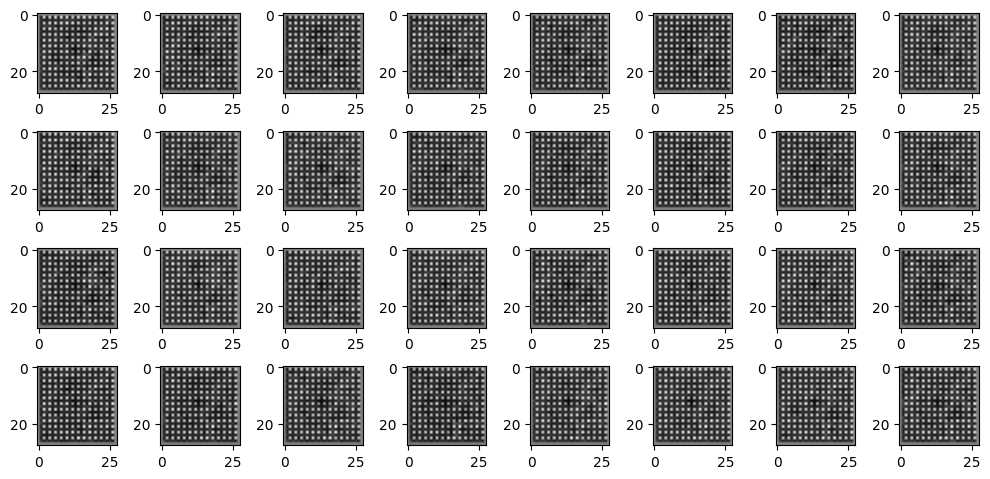




Epoch: 5 | Train MSE loss:  0.072 | Test MSE loss:  0.073 |


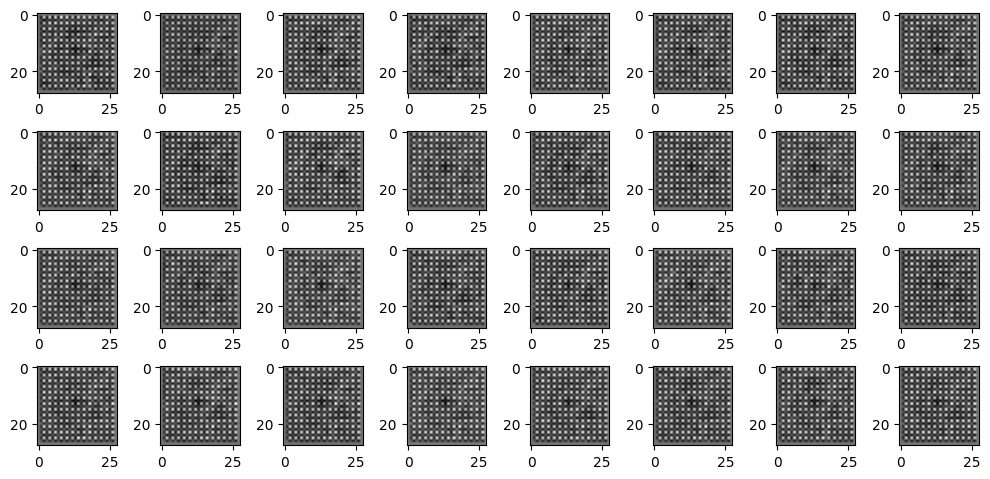




Epoch: 6 | Train MSE loss:  0.071 | Test MSE loss:  0.072 |


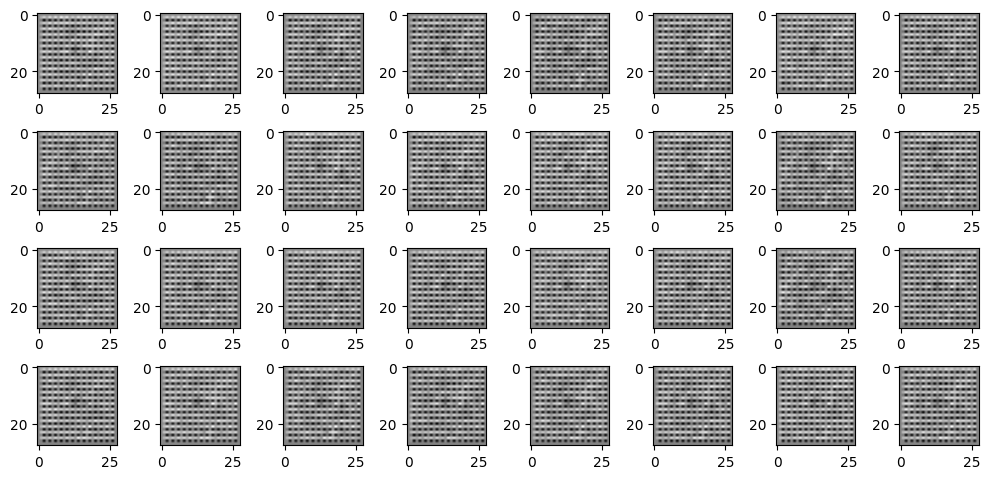




Epoch: 7 | Train MSE loss:  0.070 | Test MSE loss:  0.074 |


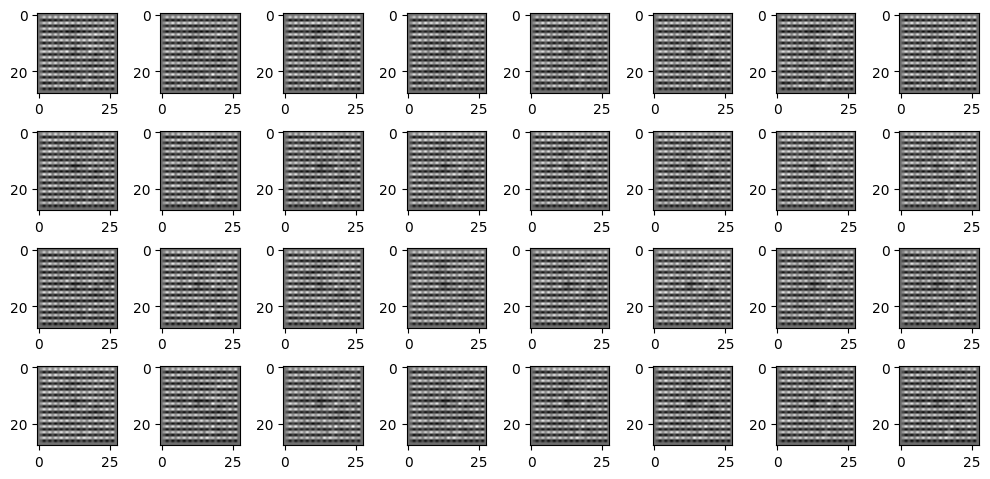




Epoch: 8 | Train MSE loss:  0.070 | Test MSE loss:  0.074 |


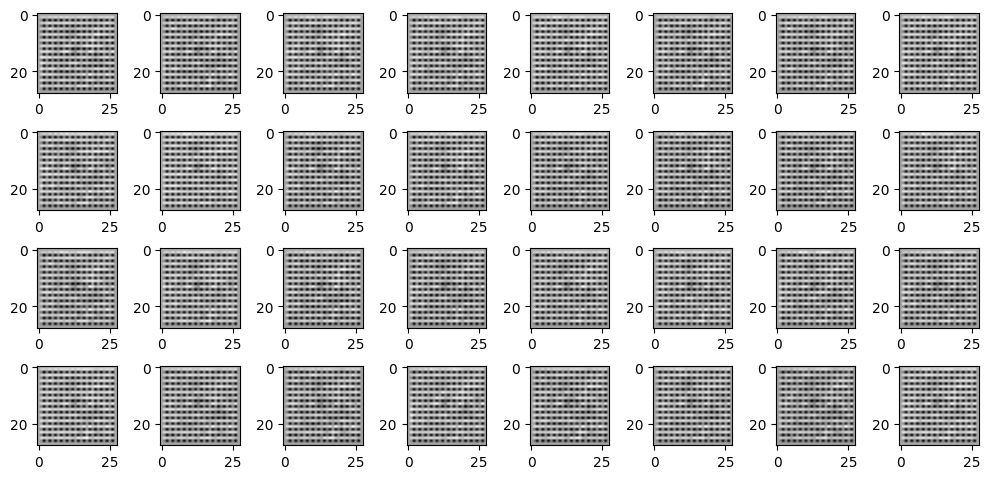




Epoch: 9 | Train MSE loss:  0.070 | Test MSE loss:  0.070 |


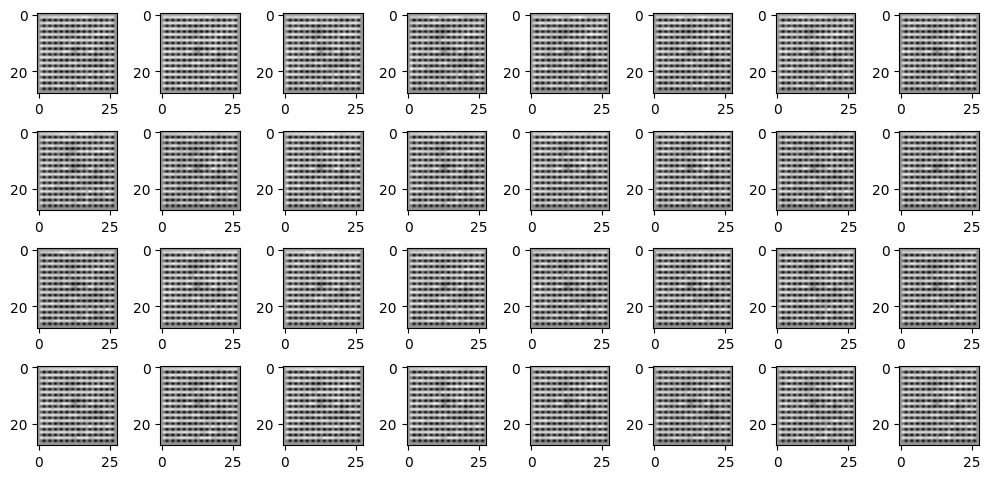




Epoch: 10 | Train MSE loss:  0.068 | Test MSE loss:  0.068 |


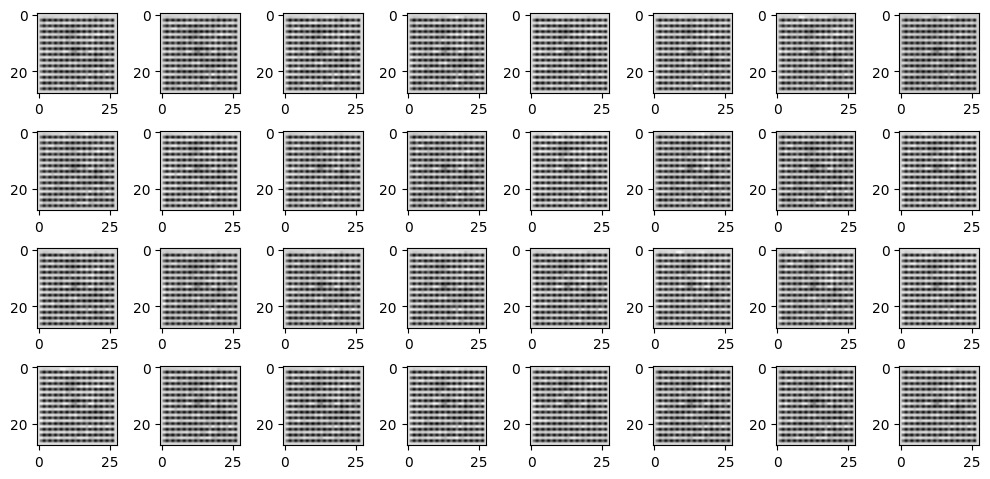




Epoch: 11 | Train MSE loss:  0.067 | Test MSE loss:  0.068 |


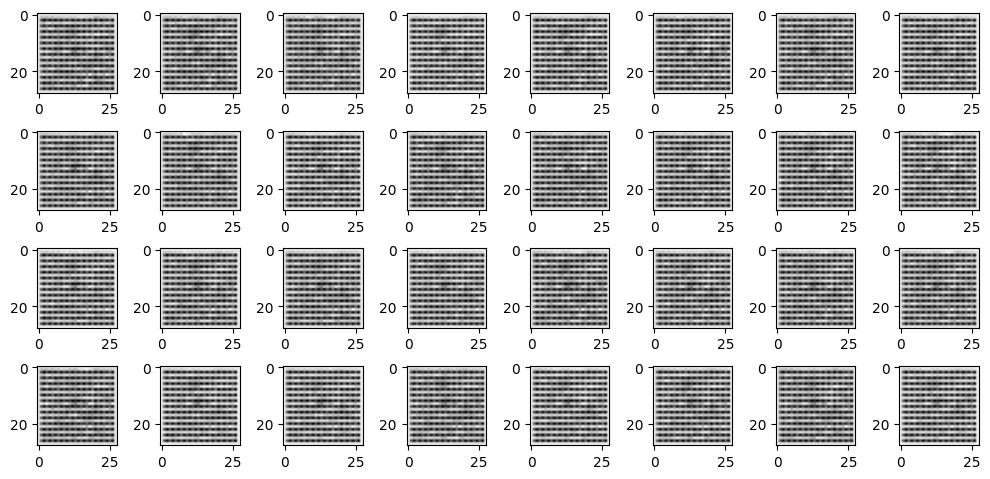




Epoch: 12 | Train MSE loss:  0.067 | Test MSE loss:  0.067 |


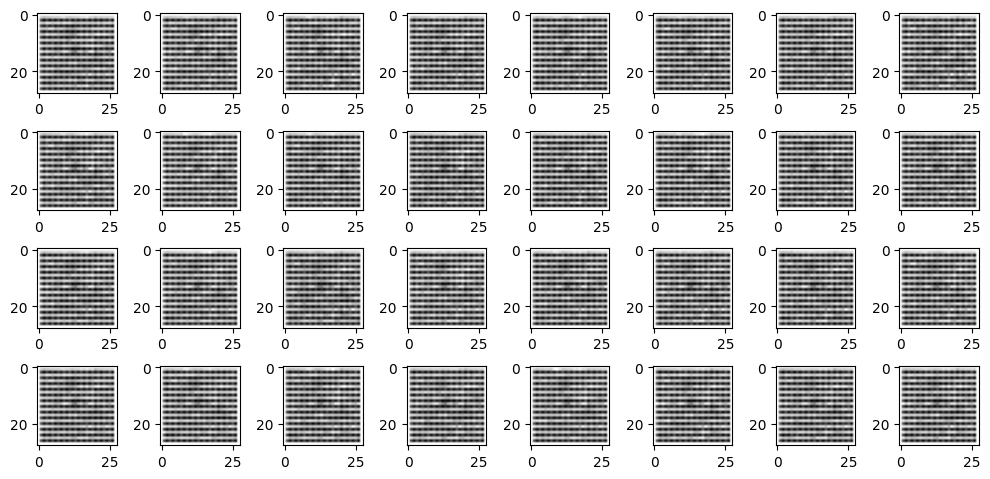




Epoch: 13 | Train MSE loss:  0.067 | Test MSE loss:  0.068 |


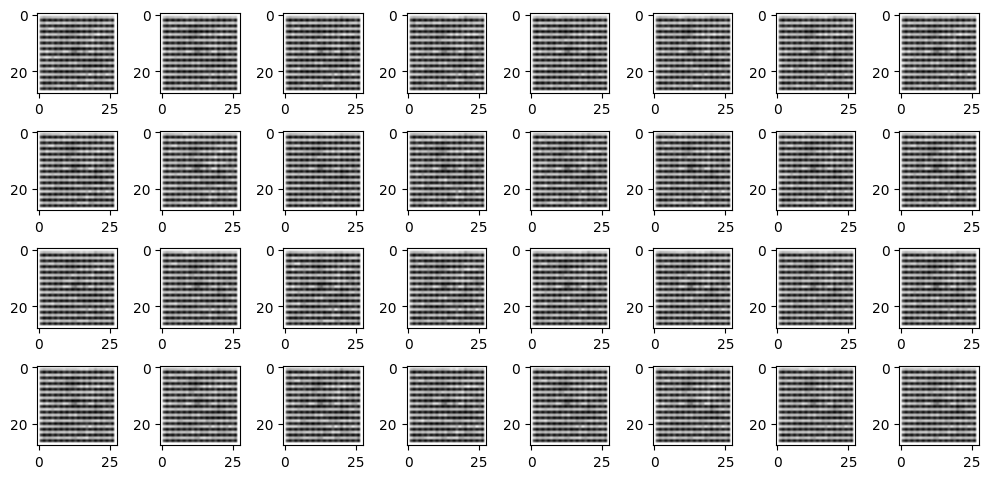




Epoch: 14 | Train MSE loss:  0.067 | Test MSE loss:  0.068 |


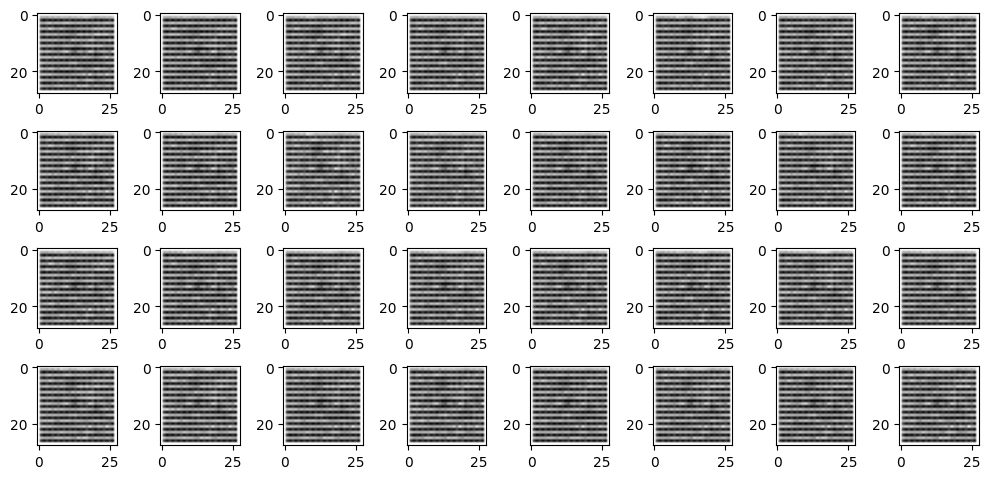




Epoch: 15 | Train MSE loss:  0.067 | Test MSE loss:  0.068 |


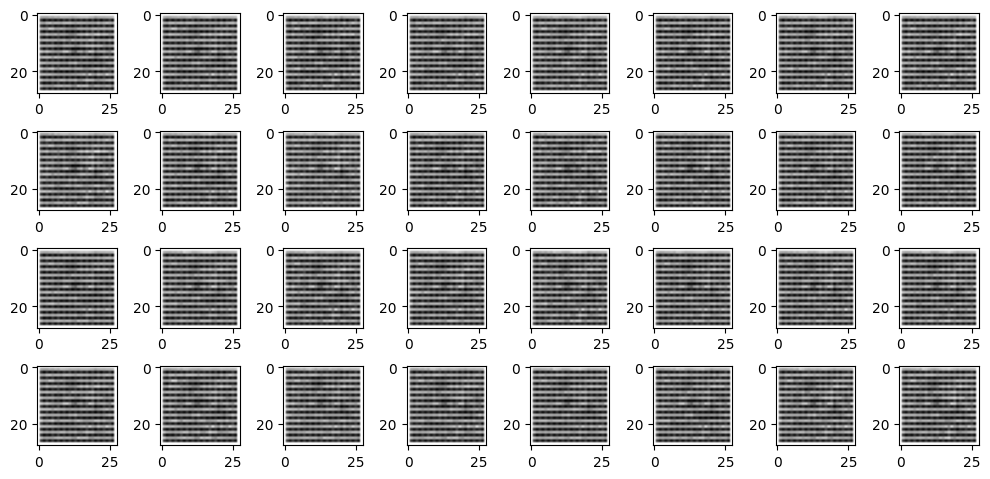




Epoch: 16 | Train MSE loss:  0.067 | Test MSE loss:  0.068 |


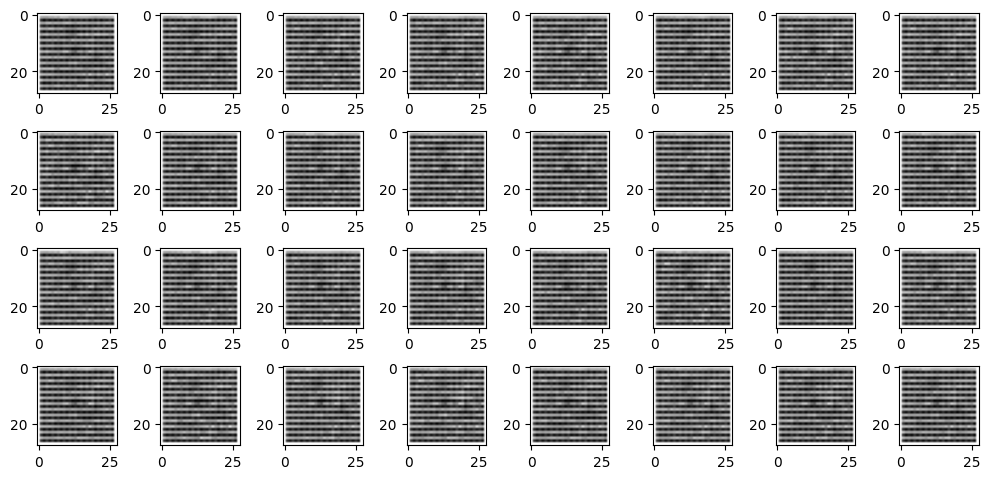




Epoch: 17 | Train MSE loss:  0.067 | Test MSE loss:  0.068 |


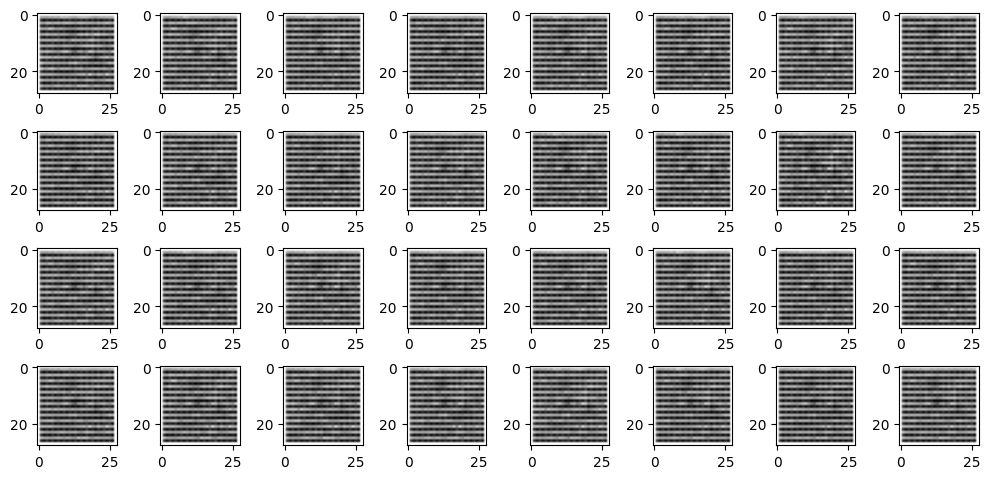




Epoch: 18 | Train MSE loss:  0.067 | Test MSE loss:  0.068 |


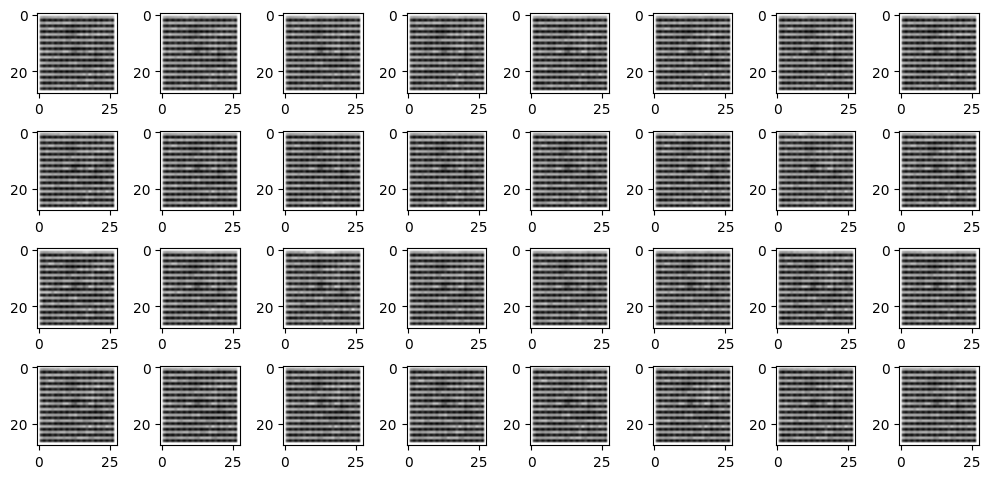




Epoch: 19 | Train MSE loss:  0.067 | Test MSE loss:  0.068 |


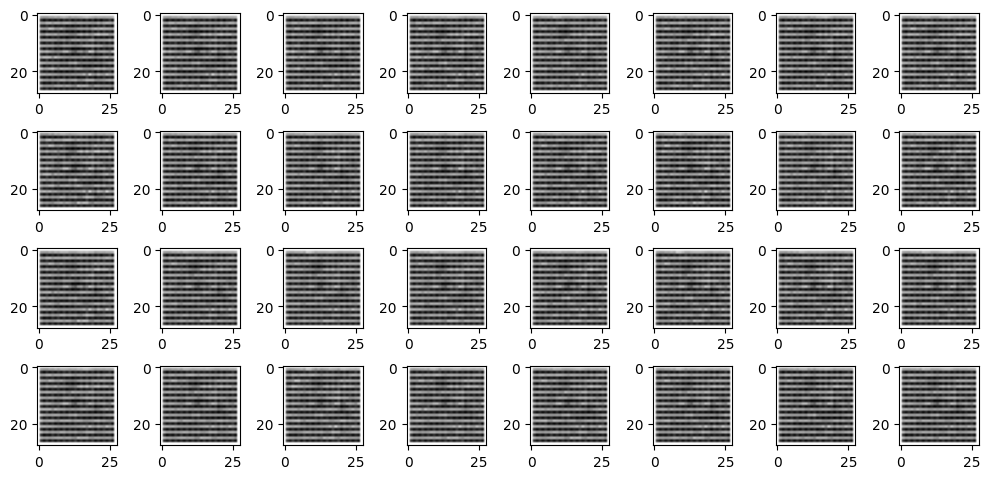




Epoch: 20 | Train MSE loss:  0.067 | Test MSE loss:  0.068 |


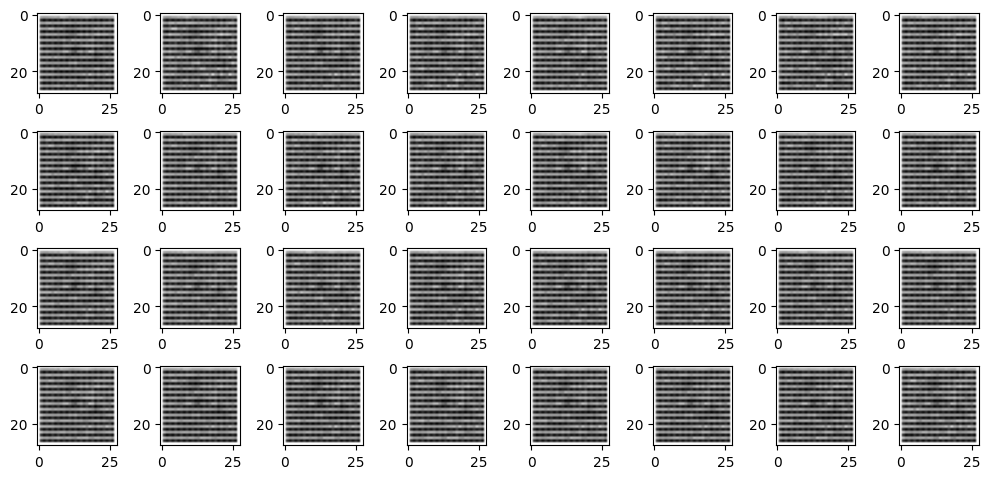

In [45]:
# Train Resnet-18 with finetuning
model_results = training_loop(epochs = EPOCHS, optimizer = opt, model = model)

In [46]:
torch.save(model_results["model"].state_dict(), "/kaggle/working/new_autoencoder.pt")

In [47]:
def visualize_results(history):
    TRAIN_LOSSES, TEST_LOSSES = history["loss"]

    plt.figure(figsize = (15, 4))

    plt.plot(range(EPOCHS), TRAIN_LOSSES, label = "Training Loss")
    plt.plot(range(EPOCHS), TEST_LOSSES, label = "Test Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.title("Loss Evolution for Train and Test Splits", fontsize = 16)

    plt.legend()
    plt.show(); plt.close("all")

    return

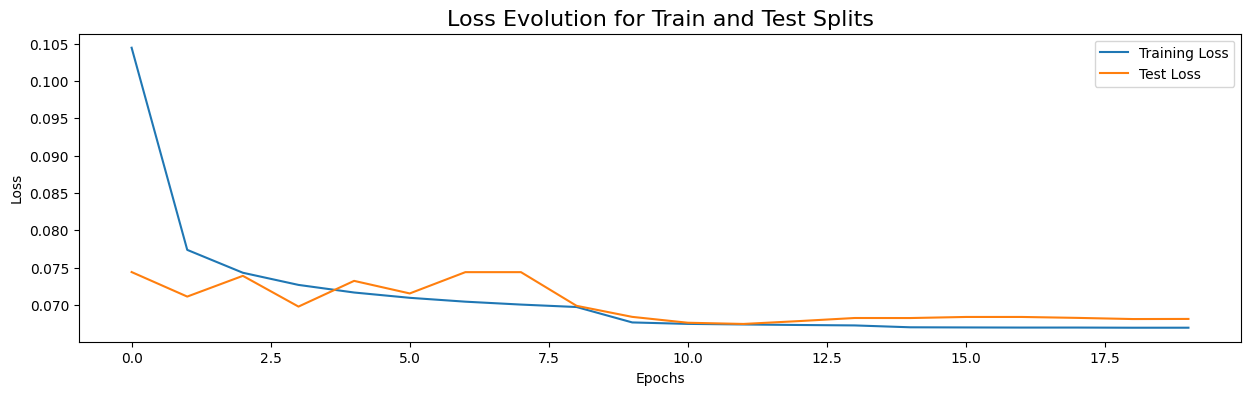

In [48]:
# VGG-13 with finetuning
visualize_results(model_results)

In [49]:
model.load_state_dict(torch.load("/kaggle/working/new_autoencoder.pt"))

<All keys matched successfully>

In [50]:
model.eval()

ParticleAutoEncoder(
  (encoder): ParticleEncoder(
    (l1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d1): Dropout(p=0.4, inplace=False)
    (l2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d2): Dropout(p=0.4, inplace=False)
    (l3): Conv2d(16, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (b3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d3): Dropout(p=0.4, inplace=False)
    (l4): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (b4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear): Linear(in_features=2304, out_features=32, bias=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): ParticleDecoder(
    (linear): Linear

Now, I generate images from the autoencoder using a previous batch extracted from the dataset.

In [51]:
# Generate images from autoencoder
s_ = model.generate_images(s[0].to(DEVICE), code_type = "image")

In [52]:
criterion(s_, s[0].to(DEVICE))

tensor(0.0723, device='cuda:0')

In [53]:
s_.max()

tensor(0.9961, device='cuda:0')

In [54]:
s_.min()

tensor(-1., device='cuda:0')

The generated images will now be visualized.

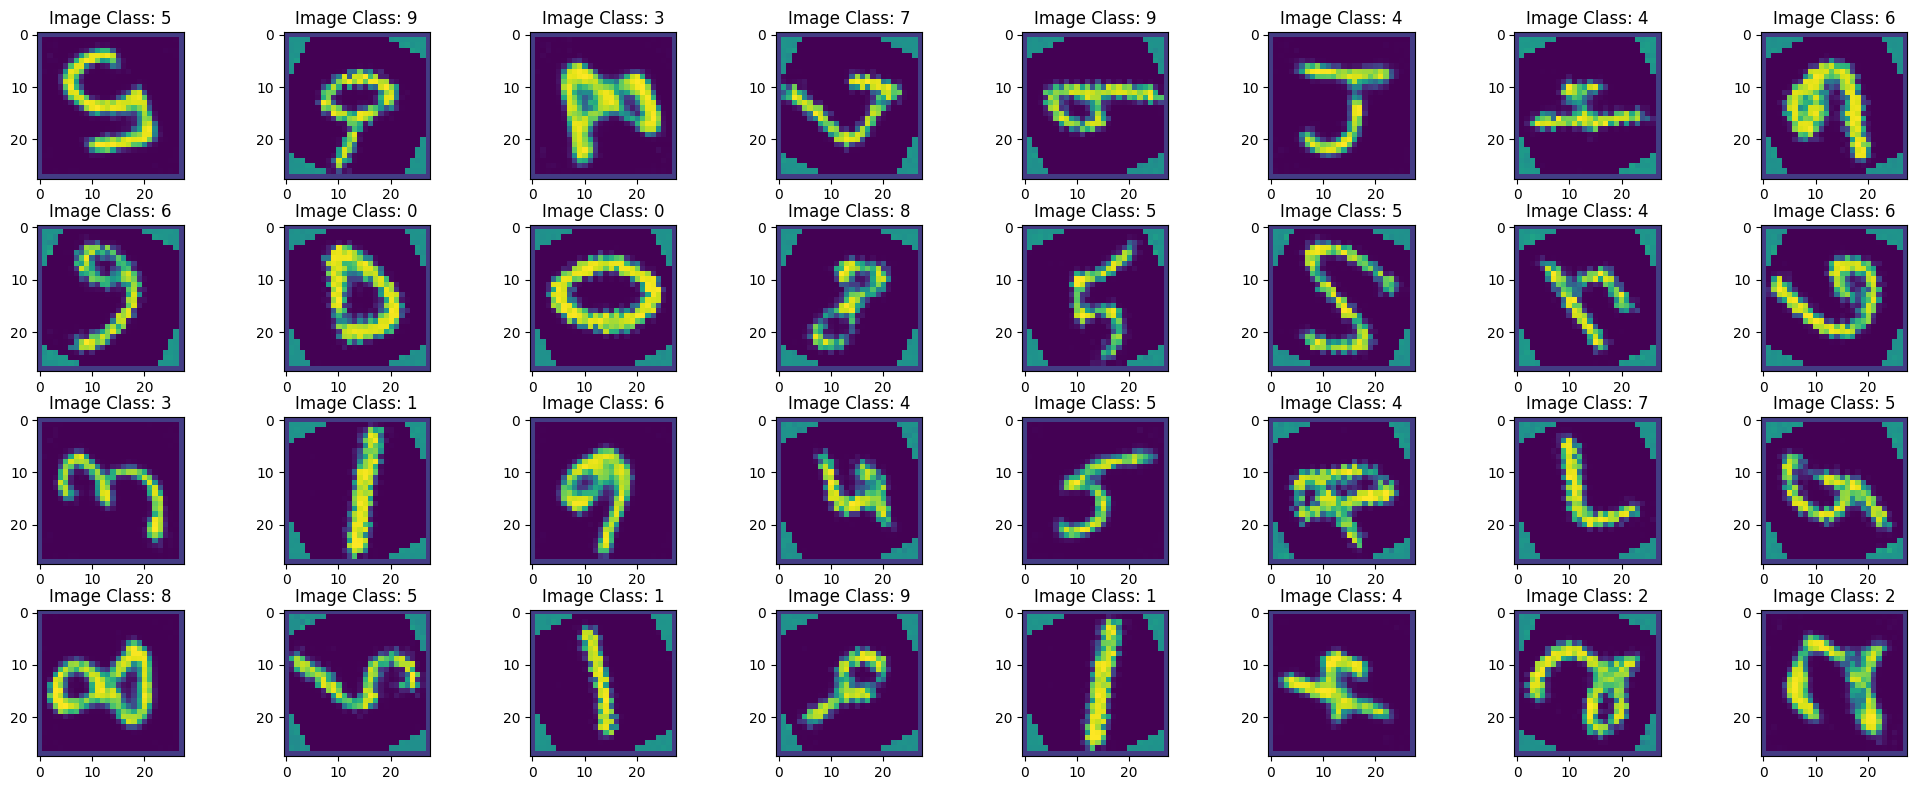

In [55]:
# Visualization of generated images
fig, ax = plt.subplots(nrows = 4, ncols = 8, figsize = (20, 8))

ix = 0
ixs = np.random.randint(low = 0, high = len(s_), size = (32,))
for i in range(4):
    for j in range(8):
        index = ixs[ix]
        ax[i, j].imshow(s_[index].cpu().squeeze(),)
        ax[i, j].set_title(f"Image Class: {s[1][index].item()}")
        ix += 1

plt.tight_layout(h_pad = 0.01)
plt.show(); plt.close('all')

To provide contrast, the original images will be visualized here.

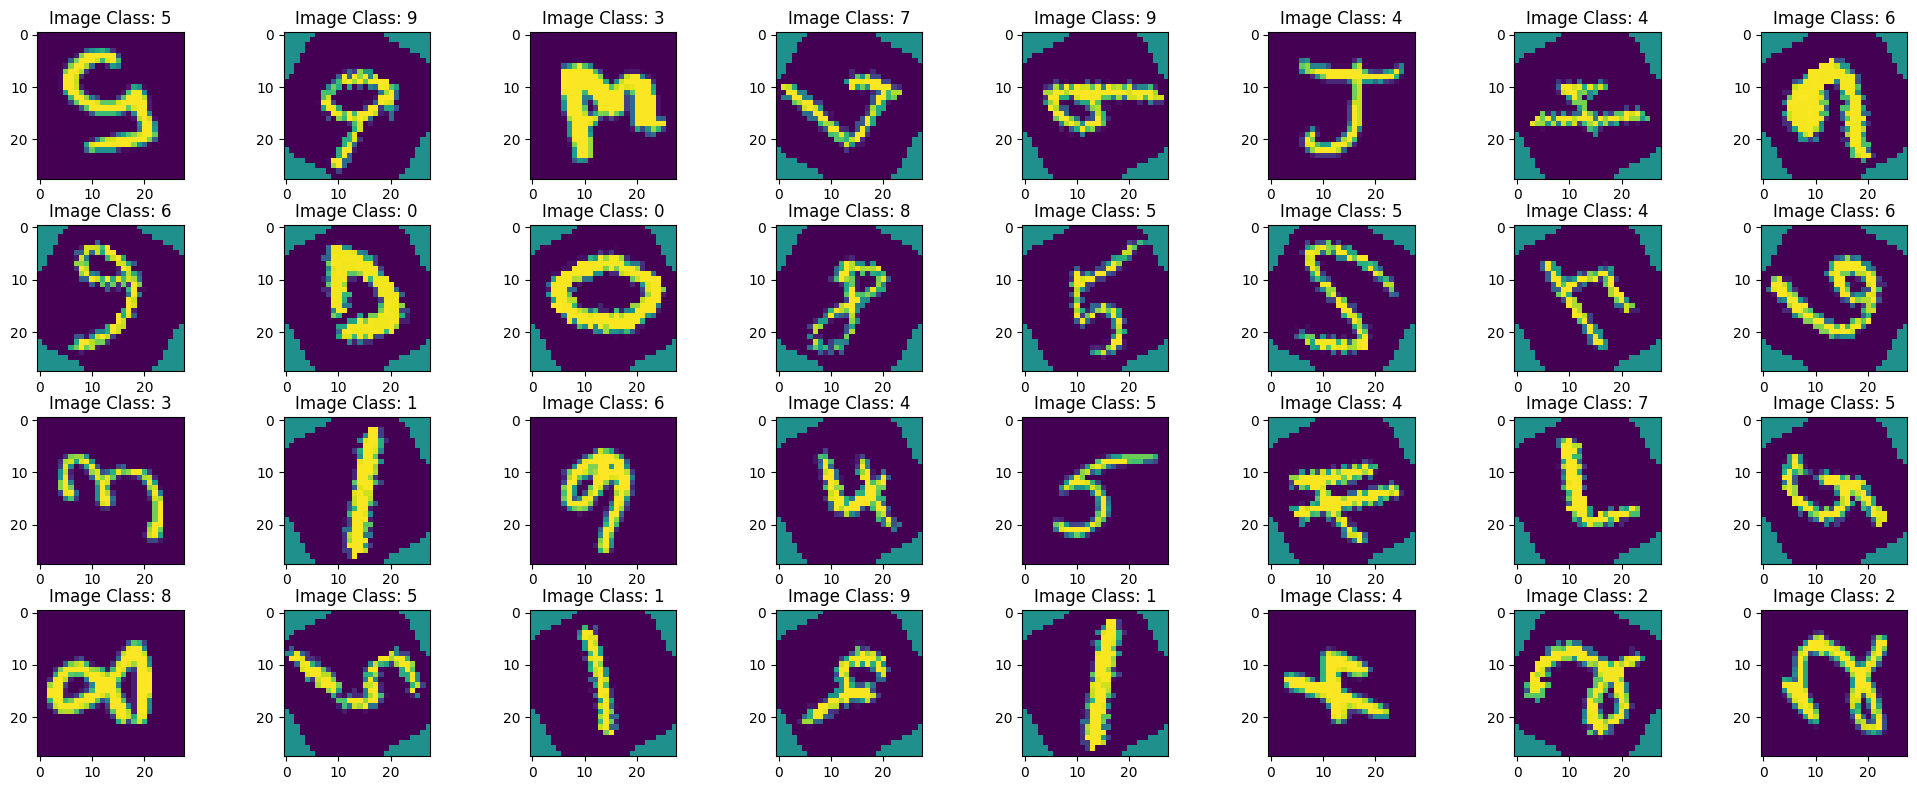

In [56]:
# Visualization of original images
fig, ax = plt.subplots(nrows = 4, ncols = 8, figsize = (20, 8))

ix = 0
for i in range(4):
    for j in range(8):
        index = ixs[ix]
        ax[i, j].imshow(s[0][index].cpu().squeeze(),)
        ax[i, j].set_title(f"Image Class: {s[1][index].item()}")
        ix += 1

plt.tight_layout(h_pad = 0.01)
plt.show(); plt.close('all')

### Observation
The generated images seem to almost completely match the original images. This speaks of the quality of the trained autoencoder.

Here, I try to see if I can generate images by basically sampling code from a normal distribution.

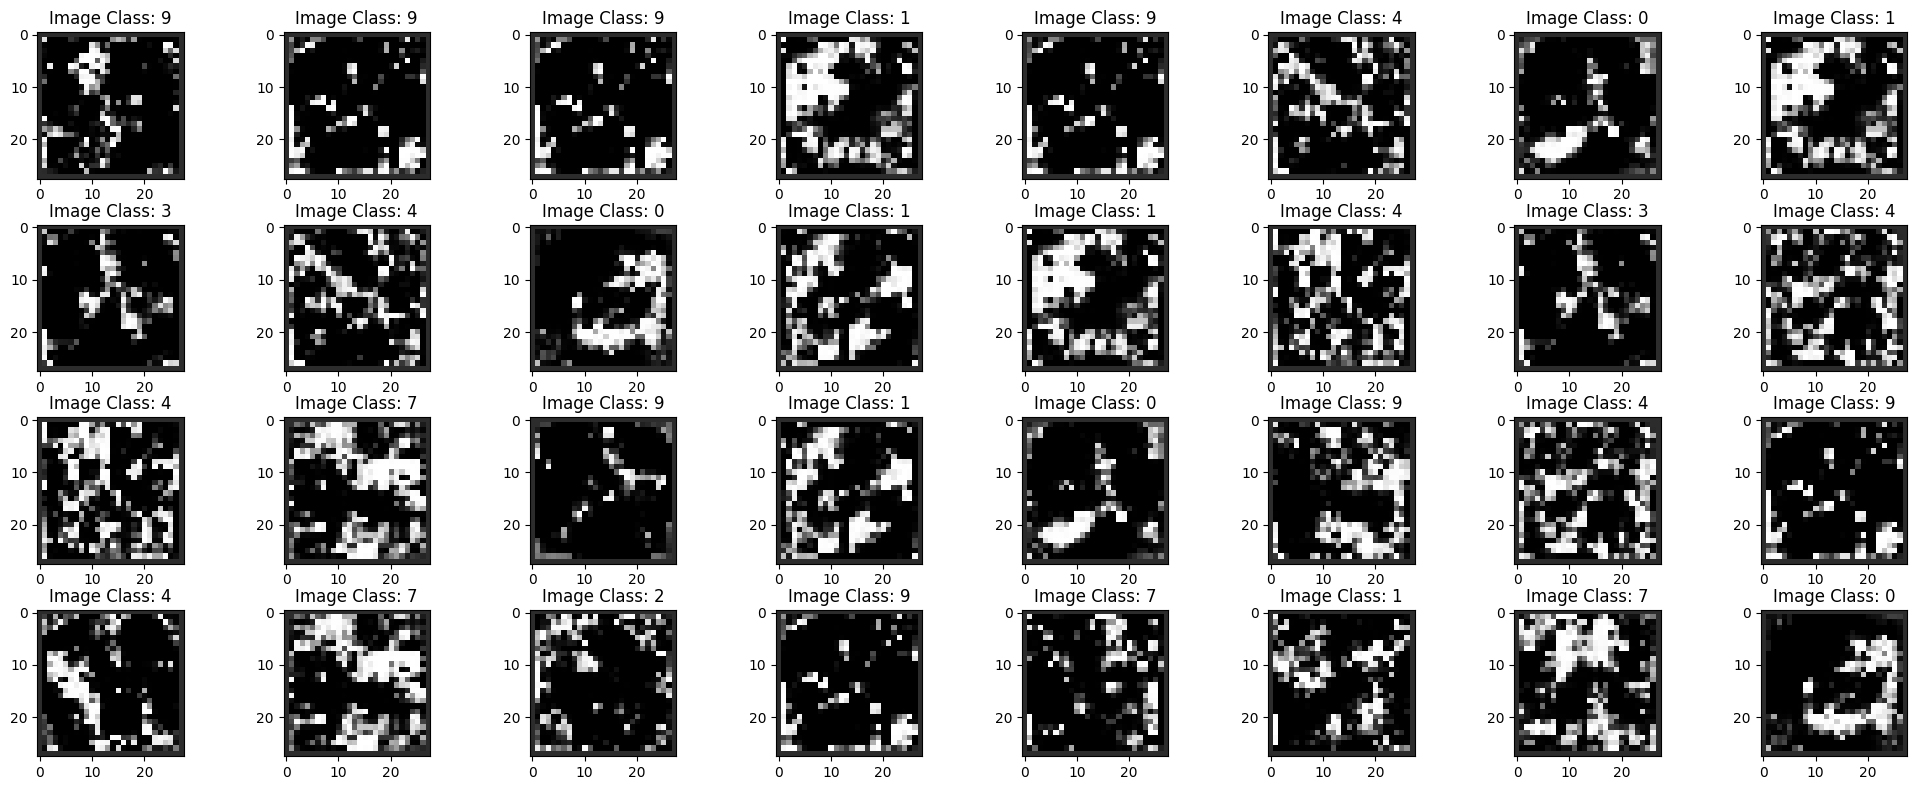

In [57]:
s__ = model.generate_images(
    x_ = torch.distributions.Normal(loc = -0.9236, scale = 135.1622).sample((32, latent_dim)).to(DEVICE)
)

fig, ax = plt.subplots(nrows = 4, ncols = 8, figsize = (20, 8))

ix = 0
for i in range(4):
    for j in range(8):
        ix = np.random.randint(low = 0, high = len(s__), size = (1,)).item()
        ax[i, j].imshow(s__[ix].cpu().squeeze(), 'gray')
        ax[i, j].set_title(f"Image Class: {s[1][ix].item()}")
        ix += 1

plt.tight_layout(h_pad = 0.01)
plt.show(); plt.close('all')

As can be seen, the results are less than encouraging.

---

<h2 align="center">Phase III: Data Distillation</h2>

__Aim__: Devise a strategy to remove the samples that the AE poorly 
reconstructs to remove outliers.

---

---

<h2 align="center">Phase IV: Lie Group Generation</h2>

__Aim__: Using the latent vectors from the AE construct an Infinitesimal 
operator that represents the rotation group but in the latent space.

---

The architecture and training scheme used for this is shown below:

<img src="LieGan.png" href="dkjd">

---

To acheive this task, I:

1. Define a LieGenerator class.
2. Define a LieDiscriminator class.
3. Train them simultaneously via zero-sum game.

In [58]:
class LieGenerator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.latent_dim = latent_dim

        self.layer_norm = nn.LayerNorm(self.latent_dim)

        self.linear1 = nn.Linear(in_features = self.latent_dim, out_features = self.latent_dim * 2)
        self.bn1 = nn.BatchNorm1d(self.latent_dim * 2)

        self.linear2 = nn.Linear(in_features = self.latent_dim * 2, out_features = self.latent_dim * 2)
        self.bn2 = nn.BatchNorm1d(self.latent_dim * 2)

        self.linear3 = nn.Linear(in_features = self.latent_dim * 2, out_features = self.latent_dim)
        
    def forward(self, x):
        x = self.layer_norm(x)
        
        x = self.bn1(self.linear1(x))
        x = F.relu(x)

        x = self.bn2(self.linear2(x))
        x = F.relu(x)

        x = self.linear3(x)
        
        return F.tanh(x)

In [59]:
class LieDiscriminator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.latent_dim = latent_dim

        self.layer_norm = nn.LayerNorm(self.latent_dim)

        self.linear1 = nn.Linear(in_features = self.latent_dim, out_features = self.latent_dim * 2)
        self.bn1 = nn.BatchNorm1d(self.latent_dim * 2)

        self.linear2 = nn.Linear(in_features = self.latent_dim * 2, out_features = self.latent_dim * 2)
        self.bn2 = nn.BatchNorm1d(self.latent_dim * 2)

        self.linear3 = nn.Linear(in_features = self.latent_dim * 2, out_features = 2)
        
    def forward(self, x):
        x = self.layer_norm(x)
        
        x = self.bn1(self.linear1(x))
        x = F.relu(x)

        x = self.bn2(self.linear2(x))
        x = F.relu(x)

        x = self.linear3(x)
        
        return F.softmax(x, dim = -1)

In [60]:
latent_dim

32

In [61]:
sample_input = torch.randn(3, latent_dim)

In [62]:
generator = LieGenerator(latent_dim = latent_dim)
discriminator = LieDiscriminator(latent_dim = latent_dim)

In [63]:
generator(sample_input).shape

torch.Size([3, 32])

In [64]:
lie_group_element = generator(sample_input)

In [65]:
(sample_input * lie_group_element).shape

torch.Size([3, 32])

In [66]:
class LieGAN(nn.Module):
    def __init__(self, generator = None, discriminator = None):
        super().__init__()

        self.discriminator = discriminator
        self.generator = generator

    def forward(self, x, noise):
        lie_group_element = self.generator(noise)
        transformed_x = x * lie_group_element

        return self.discriminator(transformed_x)

In [67]:
# Instantiate GAN model
gan_model = LieGAN(generator = generator, discriminator = discriminator).to(DEVICE)

In [68]:
generator_criterion = nn.CrossEntropyLoss().to(DEVICE)
discriminator_criterion = nn.CrossEntropyLoss().to(DEVICE)

In [69]:
generator_opt = optim.AdamW(
    params = gan_model.generator.parameters(),
    lr=LR/FACTOR,
    amsgrad = AMSGRAD,
    betas = BETAS,
    weight_decay = l2_lambda
)

In [70]:
discriminator_opt = optim.AdamW(
    params = gan_model.discriminator.parameters(),
    lr=LR/FACTOR,
    amsgrad = AMSGRAD,
    betas = BETAS,
    weight_decay = l2_lambda
)

In [71]:
def lie_training_loop(
    epochs,
    autoencoder,
    gan_model,
    generator_optimizer,
    discriminator_optimizer
):
    DISC_TRAIN_LOSSES, DISC_TEST_LOSSES = [], []
    GEN_TRAIN_LOSSES, GEN_TEST_LOSSES = [], []

    autoencoder.eval()

    for epoch in range(1, epochs + 1):
        disc_train_losses, disc_test_losses = [], []
        gen_train_losses, gen_test_losses = [], []

        for batch in iter(train_dl):
            # X, y = collate_function(batch)
            X, y = batch
            X, y = X.to(DEVICE), y.view(-1).to(DEVICE)

            with torch.no_grad():
                latent_X = autoencoder.encoder(X)

            # Train Discriminator (real latent vectors)
            gan_model.generator.eval()
            gan_model.discriminator.train()
            
            discriminator_optimizer.zero_grad()

            latent_real_labels = torch.full(size = (len(X),), fill_value = 1).to(DEVICE)

            latent_pred = gan_model.discriminator(latent_X)

            disc_real_loss = discriminator_criterion(latent_pred, latent_real_labels)

            disc_real_loss.backward()

            discriminator_optimizer.step()

            # Train Discriminator (fake latent vectors)
            discriminator_optimizer.zero_grad()
            
            latent_fake_labels = torch.full(size = (len(X),), fill_value = 0).to(DEVICE)
            
            noise = torch.distributions.Normal(loc = MEAN, scale = STD).sample(latent_X.shape).to(DEVICE)

            latent_samples = gan_model.generator(noise) * latent_X

            latent_pred = gan_model.discriminator(latent_samples)

            disc_fake_loss = discriminator_criterion(latent_pred, latent_fake_labels)

            disc_fake_loss.backward()

            discriminator_optimizer.step()

            # Train Generator
            gan_model.discriminator.eval()
            gan_model.generator.train()
            
            generator_optimizer.zero_grad()
            
            latent_fake_labels = torch.full(size = (len(X),), fill_value = 1).to(DEVICE)
            
            noise = torch.distributions.Normal(loc = MEAN, scale = STD).sample(latent_X.shape).to(DEVICE)

            latent_samples = gan_model.generator(noise) * latent_X

            latent_pred = gan_model.discriminator(latent_samples)

            gen_loss = generator_criterion(latent_pred, latent_fake_labels)

            gen_loss.backward()

            generator_optimizer.step()

            # Record Generator and Discriminator losses
            gen_train_losses.append(gen_loss.detach().item())
            disc_train_losses.append(disc_real_loss.detach().item() + disc_fake_loss.detach().item())
        
        with torch.no_grad(): # Turn off computational graph
            gan_model.eval() # Set model to evaluation mode
            
            for batch in iter(test_dl):
                # X_, y_ = collate_function(batch)
                X_, y_ = batch
                X_, y_ = X_.to(DEVICE), y_.view(-1).to(DEVICE)
                
                latent_X_ = autoencoder.encoder(X_)

                # Run Discriminator (real latent vectors)
                gan_model.generator.eval()
                gan_model.discriminator.eval()
                
                latent_real_labels_ = torch.full(size = (len(X_),), fill_value = 1).to(DEVICE)
                
                latent_pred_ = gan_model.discriminator(latent_X_)
                
                disc_real_loss_ = discriminator_criterion(latent_pred_, latent_real_labels_)
                
                # Run Discriminator (fake latent vectors)
                
                latent_fake_labels_ = torch.full(size = (len(X_),), fill_value = 0).to(DEVICE)
                
                noise_ = torch.distributions.Normal(loc = MEAN, scale = STD).sample(latent_X_.shape).to(DEVICE)
                
                latent_samples_ = gan_model.generator(noise_) * latent_X_
                
                latent_pred_ = gan_model.discriminator(latent_samples_)
                
                disc_fake_loss_ = discriminator_criterion(latent_pred_, latent_fake_labels_)
                
                # Run Generator
                latent_fake_labels_ = torch.full(size = (len(X_),), fill_value = 1).to(DEVICE)
                
                noise_ = torch.distributions.Normal(loc = MEAN, scale = STD).sample(latent_X_.shape).to(DEVICE)
                
                latent_samples_ = gan_model.generator(noise_) * latent_X_
                
                latent_pred_ = gan_model.discriminator(latent_samples_)
                
                gen_loss_ = generator_criterion(latent_pred_, latent_fake_labels_)


                gen_test_losses.append(gen_loss_.detach().item())
                disc_test_losses.append(disc_real_loss_.detach().item() + disc_fake_loss_.detach().item())


        avg_disc_train_loss = sum(disc_train_losses) / len(disc_train_losses)
        avg_disc_test_loss = sum(disc_test_losses) / len(disc_test_losses)

        avg_gen_train_loss = sum(gen_train_losses) / len(gen_train_losses)
        avg_gen_test_loss = sum(gen_test_losses) / len(gen_test_losses)

        print(
            f"Epoch: {epoch} | Discriminator Train loss: {avg_disc_train_loss: .3f} | Discriminator Test loss: {avg_disc_test_loss: .3f} |",
            f"Generator Train loss: {avg_gen_train_loss: .3f} | Generator Test loss: {avg_gen_test_loss: .3f}"
        )

        DISC_TRAIN_LOSSES.append(avg_disc_train_loss)
        DISC_TEST_LOSSES.append(avg_disc_test_loss)

        GEN_TRAIN_LOSSES.append(avg_gen_train_loss)
        GEN_TEST_LOSSES.append(avg_gen_test_loss)

    # Clear CUDA cache
    torch.cuda.empty_cache()

    return {
        "loss": {
            "generator": [DISC_TRAIN_LOSSES, DISC_TEST_LOSSES],
            "discriminator": [GEN_TRAIN_LOSSES, GEN_TEST_LOSSES],
        },
        "model": gan_model
    }

In [72]:
gan_results = lie_training_loop(
    epochs = EPOCHS,
    autoencoder = model,
    gan_model = gan_model,
    generator_optimizer = generator_opt,
    discriminator_optimizer = discriminator_opt
)

Epoch: 1 | Discriminator Train loss:  0.697 | Discriminator Test loss:  1.463 | Generator Train loss:  0.493 | Generator Test loss:  0.514
Epoch: 2 | Discriminator Train loss:  0.627 | Discriminator Test loss:  1.716 | Generator Train loss:  0.397 | Generator Test loss:  0.338
Epoch: 3 | Discriminator Train loss:  0.627 | Discriminator Test loss:  1.630 | Generator Train loss:  0.625 | Generator Test loss:  0.913
Epoch: 4 | Discriminator Train loss:  0.627 | Discriminator Test loss:  1.688 | Generator Train loss:  0.535 | Generator Test loss:  0.324
Epoch: 5 | Discriminator Train loss:  0.627 | Discriminator Test loss:  1.678 | Generator Train loss:  0.494 | Generator Test loss:  0.445
Epoch: 6 | Discriminator Train loss:  0.627 | Discriminator Test loss:  2.082 | Generator Train loss:  0.435 | Generator Test loss:  0.473
Epoch: 7 | Discriminator Train loss:  0.627 | Discriminator Test loss:  1.923 | Generator Train loss:  0.347 | Generator Test loss:  0.379
Epoch: 8 | Discriminator Tr

In [73]:
torch.save(gan_results["model"].state_dict(), "/kaggle/working/latent_gan.pt")

---

<h2 align="center">Phase V: Lie Group Action</h2>

__Aim__: Demonstrate the rotation action of the operator by applying it to an arbitrary latent vector from the dataset and decoding it using the decoder of the 
AE.

---